# OC IML Projet 5 : Catégorisez automatiquement des questions

Stack Overflow est un site célèbre de questions-réponses liées au développement informatique
développez *un système de suggestion de tag* pour le site. Celui-ci prendra la forme d’un algorithme de machine learning qui assigne automatiquement plusieurs tags pertinents à une question.


Ce notebook contient : 
- Exploration des données



## import

In [216]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
import seaborn as sns
sns.set(color_codes=True, font_scale=1.33)

import numpy as np
import pandas as pd
pd.set_option("display.max_columns", 25)

import re

from sklearn import metrics

import scipy.stats as st

import nltk
nltk.download('punkt')
nltk.download('stopwords')
from collections import defaultdict
from nltk.stem.snowball import EnglishStemmer


from sklearn.feature_extraction.text import TfidfVectorizer

import string

[nltk_data] Downloading package punkt to /Users/gregory/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/gregory/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Definitions

In [5]:
# source paths
PATH_SOURCE_QUESTIONS = '../../data/QueryResults.csv' 

## Useful functions

In [8]:
def display_missing(df):
    '''
    Display dataFrame missing values : barplots & numbers
    ouput : dataFrame containing missing numbers
    '''
    nb_lignes = df.shape[0]
    nb_missing = df.isnull().sum()
    nb_missing = nb_missing.sort_values()
    df_missing = nb_missing.to_frame()
    df_missing.rename(index=str, columns={0: "nb_missing"}, inplace=True)
    df_missing["ratio"] = 100*df_missing["nb_missing"] / nb_lignes
    fig = plt.figure(figsize=(7, 7))
    liste_name_bars = df_missing.index.values
    liste_name_bars_num = []
    for name in liste_name_bars:
        liste_name_bars_num.append("{} [{}]".format(
            name, df_missing.loc[name, "nb_missing"]))
    ax = sns.barplot(y=liste_name_bars_num, x='ratio', data=df_missing)
    plt.title('Missing lines Ratio over {} lines'.format(nb_lignes))
    ax.set(xlabel='repartition [%]')
    ax.set_xlim([0, 100])
    return df_missing

## Loading

In [6]:
# loading each sources
df_quest = pd.read_csv(PATH_SOURCE_QUESTIONS, sep=',')

### Questions/Answers

In [7]:
df_quest.head()

,Id,PostTypeId,AcceptedAnswerId,ParentId,CreationDate,DeletionDate,Score,ViewCount,Body,OwnerUserId,OwnerDisplayName,LastEditorUserId,LastEditorDisplayName,LastEditDate,LastActivityDate,Title,Tags,AnswerCount,CommentCount,FavoriteCount,ClosedDate,CommunityOwnedDate
0,50000002,2,NaN,49999948.0,2018-04-24 11:00:00,NaN,2,NaN,<p>You need to have a pointer to the <code>ma...,1983495.0,NaN,1983495.0,NaN,2018-04-24 12:14:36,2018-04-24 12:14:36,NaN,NaN,NaN,4,NaN,NaN,NaN
1,50000003,2,NaN,49995279.0,2018-04-24 11:00:00,NaN,1,NaN,<p>The old state is discarded. If you want to ...,506441.0,NaN,NaN,NaN,NaN,2018-04-24 11:00:00,NaN,NaN,NaN,3,NaN,NaN,NaN
2,50000004,2,NaN,49999911.0,2018-04-24 11:00:01,NaN,0,NaN,<p>If you are trying to achieve the above outp...,6155965.0,NaN,NaN,NaN,NaN,2018-04-24 11:00:01,NaN,NaN,NaN,6,NaN,NaN,NaN
3,50000005,1,50000164.0,NaN,2018-04-24 11:00:01,NaN,-4,63.0,<p>My table looks like this on sql server</p>...,8217447.0,NaN,3876565.0,NaN,2018-04-24 11:03:32,2018-04-24 13:15:50,How to insert an entry to a table only if it d...,<c#><sql><sql-server>,3.0,0,NaN,NaN,NaN
4,50000006,1,50117317.0,NaN,2018-04-24 11:00:01,NaN,0,199.0,<p>I have Ola Hallengren's excellent Maintenan...,9690333.0,NaN,NaN,NaN,NaN,2018-05-01 13:24:04,System DMV's missing from SQL Server 2017 mast...,<sql-server><sql-server-data-tools>,1.0,2,NaN,NaN,NaN


In [36]:
df_quest["Id"].nunique()

50000

,nb_missing,ratio
Id,0,0.000
PostTypeId,0,0.000
LastActivityDate,0,0.000
CommentCount,0,0.000
CreationDate,0,0.000
Score,0,0.000
Body,24,0.048
OwnerUserId,508,1.016
ParentId,21280,42.560
ViewCount,28792,57.584


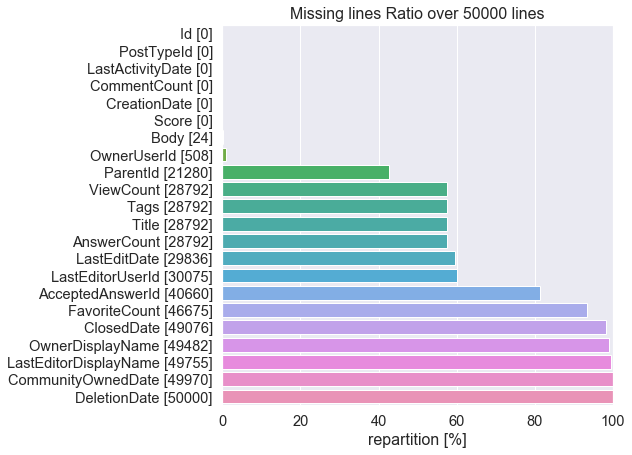

In [9]:
display_missing(df_quest)

### Filter questions

Questions only don't have ParentId.

We filter questions with no ParentId and with non-Nan Body

In [399]:
df_quest_cleaned = df_quest[df_quest["ParentId"].isna()]
df_quest_cleaned = df_quest_cleaned[df_quest_cleaned["Body"].notna()]

,nb_missing,ratio
Id,0,0.000000
LastActivityDate,0,0.000000
Score,0,0.000000
CommentCount,0,0.000000
Body,0,0.000000
PostTypeId,0,0.000000
CreationDate,0,0.000000
ViewCount,48,0.225819
Title,48,0.225819
AnswerCount,48,0.225819


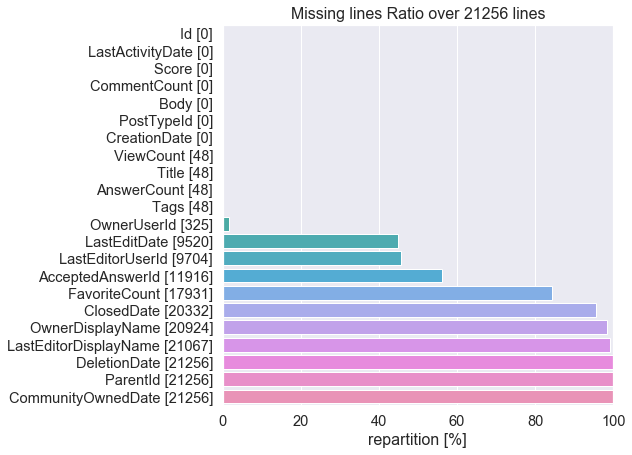

In [400]:
display_missing(df_quest_cleaned)

In [401]:
df_quest_cleaned[df_quest_cleaned.Title.isna()]

,Id,PostTypeId,AcceptedAnswerId,ParentId,CreationDate,DeletionDate,Score,ViewCount,Body,OwnerUserId,OwnerDisplayName,LastEditorUserId,LastEditorDisplayName,LastEditDate,LastActivityDate,Title,Tags,AnswerCount,CommentCount,FavoriteCount,ClosedDate,CommunityOwnedDate
655,50000860,4,NaN,NaN,2018-04-24 11:44:34,NaN,0,NaN,osgEarth is a geospatial SDK and terrain engin...,1332041.0,NaN,1332041.0,NaN,2018-04-25 07:25:46,2018-04-25 07:25:46,NaN,NaN,NaN,0,NaN,NaN,NaN
2576,50003399,5,NaN,NaN,2018-04-24 13:49:51,NaN,0,NaN,<p>This is an ambiguous tag that should not be...,1356107.0,NaN,1356107.0,NaN,2018-04-26 12:02:53,2018-04-26 12:02:53,NaN,NaN,NaN,0,NaN,NaN,NaN
2577,50003400,4,NaN,NaN,2018-04-24 13:49:51,NaN,0,NaN,DO NOT USE THIS TAG! Please find a more releva...,1481116.0,NaN,1356107.0,NaN,2018-04-26 12:06:27,2018-04-26 12:06:27,NaN,NaN,NaN,0,NaN,NaN,NaN
8467,50011191,4,NaN,NaN,2018-04-24 21:49:32,NaN,0,NaN,Use this tag for questions specific to Lightwe...,5862071.0,NaN,5862071.0,NaN,2018-04-24 21:49:32,2018-04-24 21:49:32,NaN,NaN,NaN,0,NaN,NaN,NaN
9636,50012751,5,NaN,NaN,2018-04-25 01:22:51,NaN,0,NaN,"<p><a href=""https://cloud.google.com/profiler/...",848626.0,NaN,848626.0,NaN,2018-04-25 10:21:23,2018-04-25 10:21:23,NaN,NaN,NaN,0,NaN,NaN,NaN
9637,50012752,4,NaN,NaN,2018-04-25 01:22:51,NaN,0,NaN,Google Cloud Profiler (aka Stackdriver Profile...,848626.0,NaN,848626.0,NaN,2018-04-26 04:06:31,2018-04-26 04:06:31,NaN,NaN,NaN,0,NaN,NaN,NaN
12039,50015982,5,NaN,NaN,2018-04-25 07:02:19,NaN,0,NaN,<p>Full details on downloading and using F#-Ch...,4288666.0,NaN,4288666.0,NaN,2018-04-25 12:16:54,2018-04-25 12:16:54,NaN,NaN,NaN,0,NaN,NaN,NaN
12040,50015983,4,NaN,NaN,2018-04-25 07:02:19,NaN,0,NaN,The F# Charting library implements charting su...,4288666.0,NaN,4288666.0,NaN,2018-04-25 22:24:30,2018-04-25 22:24:30,NaN,NaN,NaN,0,NaN,NaN,NaN
17297,50022969,5,NaN,NaN,2018-04-25 12:55:35,NaN,0,NaN,<p>Amazon Transcribe is an automatic speech re...,123378.0,NaN,123378.0,NaN,2018-04-25 18:45:32,2018-04-25 18:45:32,NaN,NaN,NaN,0,NaN,NaN,NaN
17298,50022970,4,NaN,NaN,2018-04-25 12:55:35,NaN,0,NaN,Amazon Transcribe is a speech recognition serv...,123378.0,NaN,123378.0,NaN,2018-04-26 05:32:48,2018-04-26 05:32:48,NaN,NaN,NaN,0,NaN,NaN,NaN


In [422]:
df_quest_cleaned[df_quest_cleaned.Id == 50060292].Body.tolist()

['<p>This library is deprecated and is no longer being used. Use <a href="/questions/tagged/boost-log" class="post-tag" title="show questions tagged &#39;boost-log&#39;" rel="tag">boost-log</a> instead. </p>\n\n<p><a href="https://meta.stackoverflow.com/questions/298315/burninate-boost-logging">Burninate boost-logging</a> </p>\n']

In [424]:
df_quest_cleaned = df_quest_cleaned[df_quest_cleaned.Title.notna()]

,nb_missing,ratio
Id,0,0.000000
LastActivityDate,0,0.000000
AnswerCount,0,0.000000
Title,0,0.000000
ViewCount,0,0.000000
Score,0,0.000000
Body,0,0.000000
CreationDate,0,0.000000
PostTypeId,0,0.000000
CommentCount,0,0.000000


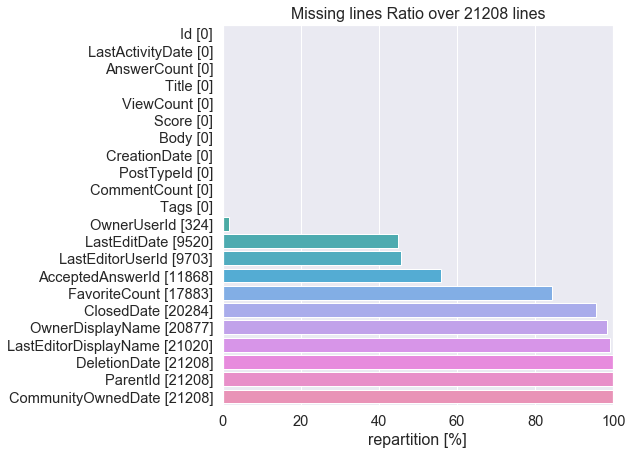

In [425]:
display_missing(df_quest_cleaned)

In [428]:
df_quest_cleaned[df_quest_cleaned["OwnerUserId"].isna()].head()

,Id,PostTypeId,AcceptedAnswerId,ParentId,CreationDate,DeletionDate,Score,ViewCount,Body,OwnerUserId,OwnerDisplayName,LastEditorUserId,LastEditorDisplayName,LastEditDate,LastActivityDate,Title,Tags,AnswerCount,CommentCount,FavoriteCount,ClosedDate,CommunityOwnedDate
117,50000152,1,50000270.0,NaN,2018-04-24 11:07:30,NaN,1,33.0,<p>I'm working on a blog. On its first page I ...,NaN,user9690627,3848833.0,NaN,2018-04-24 12:19:36,2018-04-24 12:19:36,Django - Combining Multiple Variables,<python><django>,1.0,0,NaN,NaN,NaN
140,50000185,1,50000460.0,NaN,2018-04-24 11:09:32,NaN,1,95.0,<p>I'm trying to write a PHP code that's a bit...,NaN,user9474945,4248328.0,NaN,2018-04-24 11:10:22,2018-04-24 15:47:15,Php date move to next month,<php>,4.0,2,NaN,NaN,NaN
179,50000239,1,50003124.0,NaN,2018-04-24 11:12:02,NaN,0,42.0,<p>I'm trying to append into the html code a j...,NaN,user9557101,NaN,user9557101,2018-04-24 11:29:35,2018-04-24 13:37:33,how to append a javascript function with 2 var...,<javascript><laravel>,1.0,3,NaN,NaN,NaN
711,50000932,1,NaN,NaN,2018-04-24 11:48:21,NaN,0,882.0,<p>I have some problems with 'entityManagerFac...,NaN,user7866438,3535298.0,NaN,2018-04-24 12:49:52,2018-04-24 12:49:52,Parameter 0 of constructor in com.springboot.D...,<java><hibernate><spring-boot><spring-data-jpa...,0.0,5,NaN,NaN,NaN
1291,50001710,1,NaN,NaN,2018-04-24 12:28:33,NaN,0,340.0,<p>i have a bottom navigation in main activity...,NaN,user9585742,7666442.0,NaN,2018-04-24 12:36:36,2018-04-24 12:36:36,putting recycler view above bottom navigation,<java><android><android-layout>,2.0,4,NaN,NaN,NaN


## Preparation data

In [13]:
test = "Bonjour, je suis un texte d'exemple pour le cours d'Openclassrooms. Soyez attentifs à ce cours !"

nltk.word_tokenize(test)

['Bonjour',
 ',',
 'je',
 'suis',
 'un',
 'texte',
 "d'exemple",
 'pour',
 'le',
 'cours',
 "d'Openclassrooms",
 '.',
 'Soyez',
 'attentifs',
 'à',
 'ce',
 'cours',
 '!']

In [28]:
tokenizer = nltk.RegexpTokenizer(r'\w+')
tokens_test = tokenizer.tokenize("Bonjour, je suis un texte d'exemple pour le cours d'Openclassrooms. Soyez attentifs à ce cours !")
tokens_test

['Bonjour',
 'je',
 'suis',
 'un',
 'texte',
 'd',
 'exemple',
 'pour',
 'le',
 'cours',
 'd',
 'Openclassrooms',
 'Soyez',
 'attentifs',
 'à',
 'ce',
 'cours']

In [429]:

#questions = defaultdict(set)

questions = df_quest_cleaned.filter(items=["Body"]).to_dict()
questions = questions["Body"]
print('{} questions'.format(len(questions)))

21208 questions


In [432]:
questions[4]

'<p>I have Ola Hallengren\'s excellent Maintenance Solution scripts incorporated in to a DBA tools database project.  This is maintained using SSDT 2015 with a target platform of SQL Server 2012.  The project includes references to the built-in system databases master &amp; msdb.  The project builds successfully.</p>\n\n<p>Ola has recently <a href="https://ola.hallengren.com/versions.html" rel="nofollow noreferrer">updated</a> his scripts and they now include references to new SQL Server 2017 DMV\'s, so incorporating the updated scripts into my database project generated unresolved reference errors for the new DMV\'s.  </p>\n\n<pre><code>SQL71502: Procedure: [dbo].[DatabaseBackup] has an unresolved reference to object [sys].[dm_os_host_info]\nSQL71502: Procedure: [dbo].[DatabaseBackup] has an unresolved reference to object [sys].[dm_db_log_stats]\n</code></pre>\n\n<p>Although I don\'t have SQL Server 2017 installed anywhere, I tried updating the target platform to SQL Server 2017 and t

In [433]:
tokenizer = nltk.RegexpTokenizer(r'\w+')

def freq_stats_corpora():
    '''
    Statistics about words in questions
    '''
    corpora = defaultdict(list)

    # Création d'un corpus de tokens par artiste
    for id_curr,questions_curr in questions.items():
        #print(id_curr)
        try:
            corpora[id_curr] += tokenizer.tokenize(questions_curr.lower())
        except:
            print('Question {} : Error body empty'.format(id_curr))
            

    stats, freq = dict(), dict()

    for k, v in corpora.items():
        freq[k] = fq = nltk.FreqDist(v)
        stats[k] = {'total': len(v), 'unique': len(fq.keys())}
        
    return (freq, stats, corpora)

# Récupération des comptages
freq, stats, corpora = freq_stats_corpora()
df_stats = pd.DataFrame.from_dict(stats, orient='index')

# Affichage des fréquences
#df.sort(columns='total', ascending=False)
#df = df.sort_values(by=['total'], ascending=False)
#df.head(50).plot(kind='bar', color="#f56900", title='Top 50 Rappeurs par nombre de mots')

In [434]:
df_stats.head()

,total,unique
3,68,42
4,411,192
9,346,88
10,22,21
12,67,39


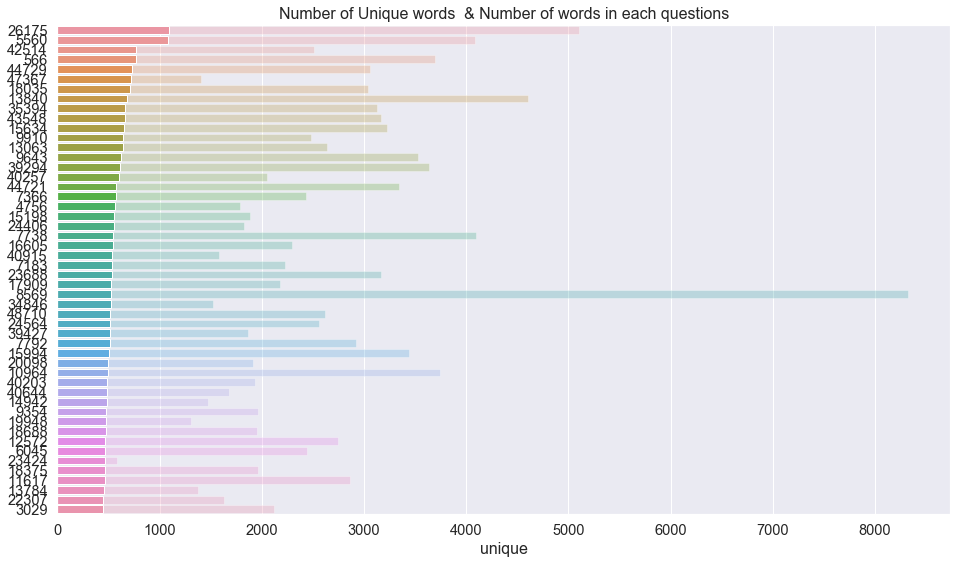

In [435]:
fig = plt.figure(figsize=(16, 9))
plt.title("Number of Unique words  & Number of words in each questions")
df_plot = df_stats.sort_values(by=['unique'], ascending=False).head(50)
ax = sns.barplot(y=df_plot.index, order= df_plot.index,
            x="total",orient="h",
            data=df_plot, alpha=0.3)
sns.barplot(y=df_plot.index, order= df_plot.index,
            x="unique",orient="h",
            data=df_plot, ax=ax)

In [436]:
df_plot.T

,26175,5560,42514,566,44729,47367,18035,13840,35394,43548,15634,9910,...,14942,9354,19948,18688,12572,6045,23424,18375,11617,13784,22307,3029
total,5103,4087,2508,3698,3059,1402,3037,4603,3126,3164,3227,2482,...,1470,1966,1311,1955,2749,2438,585,1959,2863,1378,1626,2122
unique,1091,1085,769,765,729,716,709,682,666,663,648,646,...,482,478,472,472,467,466,466,465,464,455,451,451


In [443]:
len(df_quest_cleaned.loc[14942].Body)

9799

In [444]:
df_quest_cleaned.loc[14942].Body

"<p>My outer <code>RecyclerView</code> crashes either with</p>\n\n<pre><code>IllegalArgumentException: Scrapped or attached views may not be recycled. isScrap:false isAttached:true...\n</code></pre>\n\n<p>or</p>\n\n<pre><code>IllegalStateException: The specified child already has a parent. You must call removeView() on the child's parent first.\n</code></pre>\n\n<p>Like the title suggests I have an <code>RecyclerView</code> in the list item layout of the first <code>RecyclerView</code>. This layout is used to display messages and the \ninner <code>RecyclerView</code> to display attachments that come with the message. The inner <code>RecyclerViews</code> visibility is set to either <code>GONE</code> or <code>VISIBLE</code> depending whether the message has any attachments or not. The simplified outer list item layout looks like this</p>\n\n<pre><code>ConstraintLayout\n    TextView\n    TextView\n    TextView\n    RecyclerView\n</code></pre>\n\n<p>And the part of the adapter that handles

In [449]:
tokenizer.tokenize(df_quest_cleaned.loc[14942].Body)

['p',
 'My',
 'outer',
 'code',
 'RecyclerView',
 'code',
 'crashes',
 'either',
 'with',
 'p',
 'pre',
 'code',
 'IllegalArgumentException',
 'Scrapped',
 'or',
 'attached',
 'views',
 'may',
 'not',
 'be',
 'recycled',
 'isScrap',
 'false',
 'isAttached',
 'true',
 'code',
 'pre',
 'p',
 'or',
 'p',
 'pre',
 'code',
 'IllegalStateException',
 'The',
 'specified',
 'child',
 'already',
 'has',
 'a',
 'parent',
 'You',
 'must',
 'call',
 'removeView',
 'on',
 'the',
 'child',
 's',
 'parent',
 'first',
 'code',
 'pre',
 'p',
 'Like',
 'the',
 'title',
 'suggests',
 'I',
 'have',
 'an',
 'code',
 'RecyclerView',
 'code',
 'in',
 'the',
 'list',
 'item',
 'layout',
 'of',
 'the',
 'first',
 'code',
 'RecyclerView',
 'code',
 'This',
 'layout',
 'is',
 'used',
 'to',
 'display',
 'messages',
 'and',
 'the',
 'inner',
 'code',
 'RecyclerView',
 'code',
 'to',
 'display',
 'attachments',
 'that',
 'come',
 'with',
 'the',
 'message',
 'The',
 'inner',
 'code',
 'RecyclerViews',
 'code',
 'v

In [115]:
'tEst test'.encode('utf-8').decode('utf-8')

'tEst test'

In [446]:
# Premièrement, on récupère la fréquence totale de chaque mot sur tout le corpus
# de questions
freq_totale = nltk.Counter()
for k, v in questions.items():
    freq_totale += freq[k]



In [447]:
# Deuxièmement on décide manière un peu arbitraire du nombre de mots les plus 
# fréquents à supprimer. On pourrait afficher un graphe d'évolution du nombre 
# de mots pour se rendre compte et avoir une meilleure heuristique. 
# On créé notre set de stopwords final qui cumule ainsi les 100 mots les plus 
# fréquents du corpus ainsi que l'ensemble de stopwords par défaut présent 
# dans la librairie NLTK
most_freq = freq_totale.most_common(100)
sw = set()
for tuple_freq in most_freq:
    sw.add(tuple_freq[0])
    
sw.update(tuple(nltk.corpus.stopwords.words('english')))
sw

{'0',
 '1',
 '10',
 '2',
 '3',
 '4',
 '5',
 'a',
 'about',
 'above',
 'after',
 'again',
 'against',
 'ain',
 'all',
 'am',
 'amp',
 'an',
 'and',
 'android',
 'any',
 'app',
 'are',
 'aren',
 "aren't",
 'as',
 'at',
 'be',
 'because',
 'been',
 'before',
 'being',
 'below',
 'between',
 'both',
 'but',
 'by',
 'c',
 'can',
 'class',
 'code',
 'com',
 'couldn',
 "couldn't",
 'd',
 'data',
 'did',
 'didn',
 "didn't",
 'div',
 'do',
 'does',
 'doesn',
 "doesn't",
 'doing',
 'don',
 "don't",
 'down',
 'during',
 'each',
 'error',
 'false',
 'few',
 'file',
 'for',
 'from',
 'function',
 'further',
 'get',
 'gt',
 'had',
 'hadn',
 "hadn't",
 'has',
 'hasn',
 "hasn't",
 'have',
 'haven',
 "haven't",
 'having',
 'he',
 'her',
 'here',
 'hers',
 'herself',
 'him',
 'himself',
 'his',
 'how',
 'href',
 'html',
 'https',
 'i',
 'id',
 'if',
 'import',
 'in',
 'int',
 'into',
 'is',
 'isn',
 "isn't",
 'it',
 "it's",
 'its',
 'itself',
 'java',
 'js',
 'just',
 'li',
 'like',
 'll',
 'lt',
 'm',


In [448]:
nltk.corpus.stopwords.words('english')

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

In [450]:
def freq_stats_corpora2():
    '''
    Statistics about significant words in questions
    '''
    corpora = defaultdict(list)

    # Création d'un corpus de tokens par artiste
    for id_curr,questions_curr in questions.items():
        #print(id_curr)
        try:
            tokens = tokenizer.tokenize(questions_curr.lower())
            corpora[id_curr] += [w for w in tokens if not w in list(sw)]
        except:
            print('Question {} : Error body empty'.format(id_curr))
            

    stats, freq = dict(), dict()

    for k, v in corpora.items():
        freq[k] = fq = nltk.FreqDist(v)
        stats[k] = {'total': len(v), 'unique': len(fq.keys())}
        
    return (freq, stats, corpora)

freq2, stats2, corpora2 = freq_stats_corpora2()

In [451]:
df_stats2 = pd.DataFrame.from_dict(stats2, orient='index')
df_stats2.head()

,total,unique
3,31,22
4,201,119
9,137,50
10,8,8
12,31,23


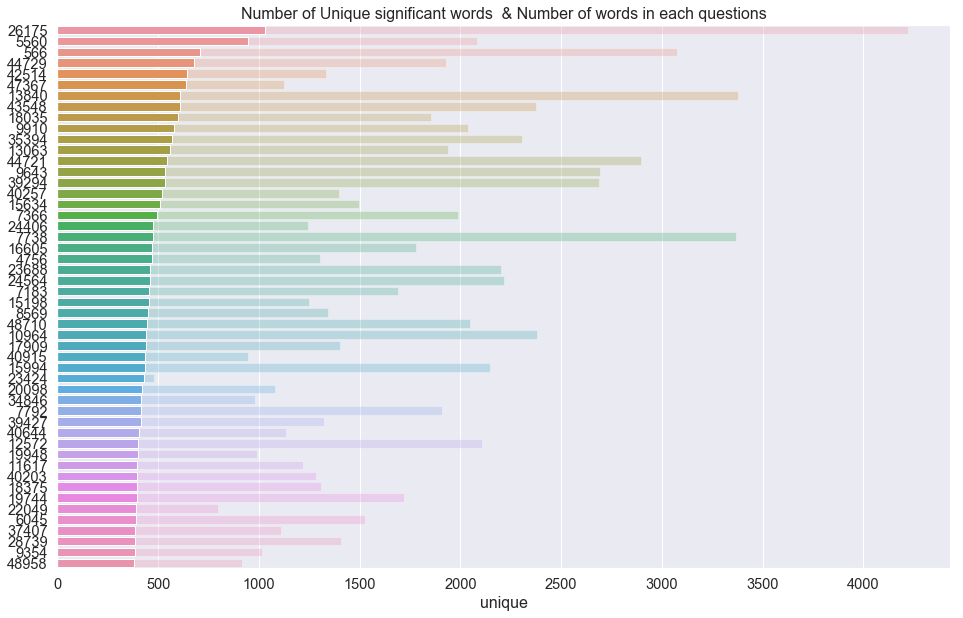

In [452]:
fig = plt.figure(figsize=(16, 10))
plt.title("Number of Unique significant words  & Number of words in each questions")
df_plot = df_stats2.sort_values(by=['unique'], ascending=False).head(50)
ax = sns.barplot(y=df_plot.index, order= df_plot.index,
            x="total",orient="h",
            data=df_plot, alpha=0.3)
sns.barplot(y=df_plot.index, order= df_plot.index,
            x="unique",orient="h",
            data=df_plot, ax=ax)

In [453]:
df_plot.head()

,total,unique
26175,4219,1031
5560,2082,948
566,3076,707
44729,1927,680
42514,1335,645


In [454]:
df_stats2.loc[26175]

total     4219
unique    1031
Name: 26175, dtype: int64

In [455]:
df_stats.loc[26175]

total     5103
unique    1091
Name: 26175, dtype: int64

In [456]:
def freq_stats_corpora3():
    '''
    Statistics about stems of words in questions
    '''
    corpora = defaultdict(list)
    stemmer = EnglishStemmer()
    # Création d'un corpus de tokens par artiste
    for id_curr,questions_curr in questions.items():
        try:
            tokens = tokenizer.tokenize(questions_curr.lower())
            corpora[id_curr] += \
                [stemmer.stem(w) for w in tokens if not w in list(sw)]
        except:
            print('Question {} : Error body empty'.format(id_curr))
            
    stats, freq = dict(), dict()

    for k, v in corpora.items():
        freq[k] = fq = nltk.FreqDist(v)
        stats[k] = {'total': len(v), 'unique': len(fq.keys())}
        
    return (freq, stats, corpora)

freq3, stats3, corpora3 = freq_stats_corpora3()

df_stats3 = pd.DataFrame.from_dict(stats3, orient='index')
df_stats3.head()

,total,unique
3,31,22
4,201,108
9,137,50
10,8,8
12,31,23


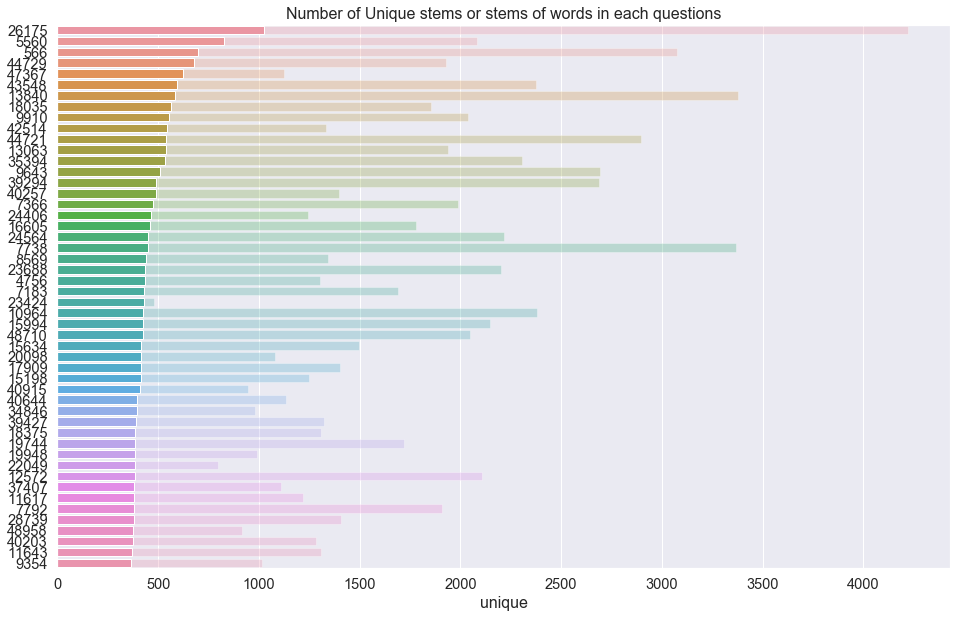

In [457]:
fig = plt.figure(figsize=(16, 10))
plt.title("Number of Unique stems or stems of words in each questions")
df_plot = df_stats3.sort_values(by=['unique'], ascending=False).head(50)
ax = sns.barplot(y=df_plot.index, order= df_plot.index,
            x="total",orient="h",
            data=df_plot, alpha=0.3)
sns.barplot(y=df_plot.index, order= df_plot.index,
            x="unique",orient="h",
            data=df_plot, ax=ax)

In [458]:
df_plot.head()

,total,unique
26175,4219,1027
5560,2082,828
566,3076,700
44729,1927,679
47367,1123,624


In [459]:
corpus = [
...     'This is the first document.',
...     'This document is the second document.',
...     'And this is the third one.',
...     'Is this the first document?',
... ]
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(corpus)
print(vectorizer.get_feature_names())
print(X.shape)
(4, 9)

['and', 'document', 'first', 'is', 'one', 'second', 'the', 'third', 'this']
(4, 9)


(4, 9)

In [460]:
X

<4x9 sparse matrix of type '<class 'numpy.float64'>'
	with 21 stored elements in Compressed Sparse Row format>

In [461]:
print(X)

  (0, 8)	0.38408524091481483
  (0, 3)	0.38408524091481483
  (0, 6)	0.38408524091481483
  (0, 2)	0.5802858236844359
  (0, 1)	0.46979138557992045
  (1, 8)	0.281088674033753
  (1, 3)	0.281088674033753
  (1, 6)	0.281088674033753
  (1, 1)	0.6876235979836938
  (1, 5)	0.5386476208856763
  (2, 8)	0.267103787642168
  (2, 3)	0.267103787642168
  (2, 6)	0.267103787642168
  (2, 0)	0.511848512707169
  (2, 7)	0.511848512707169
  (2, 4)	0.511848512707169
  (3, 8)	0.38408524091481483
  (3, 3)	0.38408524091481483
  (3, 6)	0.38408524091481483
  (3, 2)	0.5802858236844359
  (3, 1)	0.46979138557992045


In [462]:
stemmer = EnglishStemmer()

def stem_tokens(tokens, stemmer):
    stemmed = []
    for item in tokens:
        stemmed.append(stemmer.stem(item))
    return stemmed

def tokenize(text):
    tokens = nltk.word_tokenize(text)
    stems = stem_tokens(tokens, stemmer)
    return stems


token_dict = dict()


# for each questions, prepare token : lower, no ponctuation
for id_curr,questions_curr in questions.items():
    text = questions_curr
    try:
        # lower text
        lowers = text.lower()
        
        # prepare dictionnary of translation to suppress ponctuation
        replace_punctuation = str.maketrans(string.punctuation, 
                                            ' '*len(string.punctuation))
        #no_punctuation = lowers.translate(str.maketrans('','',
        #                                                string.punctuation))
        
        # into text, replace ponctuations by spaces
        no_punctuation = lowers.translate(replace_punctuation)
        
        # save text into dict output
        token_dict[id_curr] = no_punctuation
    except:
        print('Question {} : Error body empty'.format(id_curr))


In [463]:
# prepare tf-idf calculation
tfidf = TfidfVectorizer(tokenizer=tokenize, stop_words=sw, analyzer='word')
# calculate tf-idf
values = tfidf.fit_transform(token_dict.values())

/anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ["'d", "'s", 'abov', 'ani', 'becaus', 'befor', 'could', 'doe', 'dure', 'fals', 'might', 'must', "n't", 'need', 'noreferr', 'onc', 'onli', 'ourselv', 'sha', 'themselv', 'valu', 'veri', 'whi', 'wo', 'would', 'yourselv'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


In [464]:
names = tfidf.get_feature_names()

In [465]:
names[40401:40421]

['charindex',
 'charinput',
 'chario',
 'charisma',
 'chariti',
 'charl',
 'charleslbry',
 'charlesshang',
 'charlett',
 'charli',
 'charliekassel',
 'charlott',
 'charm',
 'charmap',
 'charmhomenavtask',
 'charmhomenavtaskcel',
 'charmlistcel',
 'charmlistview',
 'charnumb',
 'charon']

In [467]:
names[136617]

'valuestyl'

In [475]:
print(values[4])

  (0, 123049)	0.14696002437693112
  (0, 117067)	0.11902051206291953
  (0, 105059)	0.06838425826265959
  (0, 40557)	0.020542672408962834
  (0, 58587)	0.021973310532356075
  (0, 97082)	0.1856496953115701
  (0, 70200)	0.12376646354104673
  (0, 58426)	0.06259845765094085
  (0, 86108)	0.047713378597386454
  (0, 121868)	0.022058045882719993
  (0, 115446)	0.0625618154545394
  (0, 74721)	0.08997925338153025
  (0, 49492)	0.05015679167287044
  (0, 130903)	0.027873306653482404
  (0, 48716)	0.1101888123180536
  (0, 105642)	0.08358941071853808
  (0, 86105)	0.03773424803107451
  (0, 123423)	0.22544592910929775
  (0, 9071)	0.03602807311766312
  (0, 127414)	0.05119870426707029
  (0, 102873)	0.061974602304655096
  (0, 9033)	0.03778928218642824
  (0, 74649)	0.0440512502034944
  (0, 109732)	0.16937494205003314
  (0, 37304)	0.03195511287797495
  :	:
  (0, 26583)	0.04308840932482271
  (0, 84733)	0.02737211259420269
  (0, 83380)	0.022210303439552343
  (0, 129429)	0.044989626690765123
  (0, 69149)	0.03715989

In [472]:
values[4][(0, 127028)]

0.10706507824573452

In [476]:
type(values[4])

scipy.sparse.csr.csr_matrix

In [477]:
values[4].getrow(0).toarray().shape

(1, 144749)

In [478]:
values[4].indices

array([127028, 123049, 124084, 113126,   5187, 136505, 140626,  99315,
       131664,  46856, 116226,  45550,  49481,  43033,  43034,  43035,
        43036,  10777,   4774,  12427,   6355], dtype=int32)

In [486]:
values[4].indices.shape

(21,)

In [489]:
values[0]

<1x144749 sparse matrix of type '<class 'numpy.float64'>'
	with 23 stored elements in Compressed Sparse Row format>

In [497]:
n_quest = 0

dict_names_quest_curr = dict()
for indice_curr, value_curr in zip(values[n_quest].indices, 
                                   values[n_quest].data):
    dict_names_quest_curr[names[indice_curr]] = value_curr
pd.DataFrame(data=dict_names_quest_curr, index=[n_quest]).T

,0
tabl,0.127197
look,0.059209
sql,0.079258
server,0.064190
wordid,0.800993
word,0.186025
1214,0.173215
pen,0.125802
1215,0.182380
men,0.157402


In [502]:
df_quest_cleaned.iloc[0].Body

"<p>My table looks like this  on sql server</p>\n\n<pre><code>wordId     word      \n----------------\n1214       pen           \n1215       men    \n1216       cat  \n</code></pre>\n\n<p>WordId and word is being passed with the stored procedure and,I need to check on my stored procedure if the wordId already exists on the table or not, and only if the wordId doesn't exists I need to execute the insert statement.  </p>\n"

In [483]:
questions[3]

"<p>My table looks like this  on sql server</p>\n\n<pre><code>wordId     word      \n----------------\n1214       pen           \n1215       men    \n1216       cat  \n</code></pre>\n\n<p>WordId and word is being passed with the stored procedure and,I need to check on my stored procedure if the wordId already exists on the table or not, and only if the wordId doesn't exists I need to execute the insert statement.  </p>\n"

In [503]:
test = "Bonjour, je suis un texte d'exemple pour le cours d'Openclassrooms. Soyez attentifs à ce cours !"
tokens = tokenizer.tokenize(test.lower())
list(nltk.bigrams(tokens))

[('bonjour', 'je'),
 ('je', 'suis'),
 ('suis', 'un'),
 ('un', 'texte'),
 ('texte', 'd'),
 ('d', 'exemple'),
 ('exemple', 'pour'),
 ('pour', 'le'),
 ('le', 'cours'),
 ('cours', 'd'),
 ('d', 'openclassrooms'),
 ('openclassrooms', 'soyez'),
 ('soyez', 'attentifs'),
 ('attentifs', 'à'),
 ('à', 'ce'),
 ('ce', 'cours')]